In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, classification_report
)

from tqdm import tqdm


In [6]:
class WikiArtDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [
            d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))
        ]
        self.classes.sort() 
        self.files = []
        for label, cls in enumerate(self.classes):
            class_dir = os.path.join(root_dir, cls)
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                if os.path.isfile(file_path):
                    self.files.append((file_path, label))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        image = Image.open(file_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


### Paths and Transforms
data_path = r"C:\Users\yozev\OneDrive\Desktop\artFiltered"

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = WikiArtDataset(root_dir=data_path, transform=transform_train)

print("Loading dataset...")
print(f"Total images: {len(full_dataset)}")

# Train/Val/Test split
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1
train_size = int(train_ratio * len(full_dataset))
val_size = int(val_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

# Dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# Number of classes
num_classes = len(full_dataset.classes)

print(f"Number of Classes: {num_classes}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Loading dataset...
Total images: 64751
Train size: 51800, Val size: 6475, Test size: 6476
Number of Classes: 13
Using device: cuda


In [7]:
input_dim = 224 * 224 * 3

class DeepArtClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeepArtClassifier, self).__init__()

        self.hidden1 = nn.Linear(input_dim, 2048)
        self.bn1     = nn.BatchNorm1d(2048)

        self.hidden2 = nn.Linear(2048, 1536)
        self.bn2     = nn.BatchNorm1d(1536)

        self.hidden3 = nn.Linear(1536, 1024)
        self.bn3     = nn.BatchNorm1d(1024)

        self.hidden4 = nn.Linear(1024, 768)
        self.bn4     = nn.BatchNorm1d(768)

        self.hidden5 = nn.Linear(768, 512)
        self.bn5     = nn.BatchNorm1d(512)

        self.hidden6 = nn.Linear(512, 384)
        self.bn6     = nn.BatchNorm1d(384)

        self.hidden7 = nn.Linear(384, 256)
        self.bn7     = nn.BatchNorm1d(256)

        # Final output
        self.output = nn.Linear(256, output_dim)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.hidden1(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn2(self.hidden2(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn3(self.hidden3(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn4(self.hidden4(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn5(self.hidden5(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn6(self.hidden6(x)))
        x = self.dropout(x)

        x = torch.relu(self.bn7(self.hidden7(x)))
        x = self.dropout(x)

        logits = self.output(x)
        return logits

model = DeepArtClassifier(input_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
import copy

epochs = 30
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []
val_accuracies = []

print("Starting training...\n")
for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}/{epochs}")
    print("-" * 40)

    # TRAINING LOOP 
    model.train()
    running_train_loss = 0.0

    pbar_train = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_idx, (images, labels) in pbar_train:
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        avg_loss = running_train_loss / ((batch_idx + 1) * train_loader.batch_size)
        pbar_train.set_postfix({"train_loss": f"{avg_loss:.4f}"})

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    #VALIDATION LOOP
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc  = correct / total
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")

    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered (no improvement in validation loss).")
            break


Starting training...

Epoch 1/30
----------------------------------------


Train Loss: 2.4465 | Val Loss: 2.3649 | Val Acc: 0.1816
Epoch 2/30
----------------------------------------


Train Loss: 2.3737 | Val Loss: 2.3445 | Val Acc: 0.1951
Epoch 3/30
----------------------------------------


Train Loss: 2.3428 | Val Loss: 2.3054 | Val Acc: 0.2091
Epoch 4/30
----------------------------------------


Train Loss: 2.3137 | Val Loss: 2.2906 | Val Acc: 0.2133
Epoch 5/30
----------------------------------------


Train Loss: 2.2876 | Val Loss: 2.2620 | Val Acc: 0.2300
Epoch 6/30
----------------------------------------


Train Loss: 2.2580 | Val Loss: 2.2392 | Val Acc: 0.2361
Epoch 7/30
----------------------------------------


Train Loss: 2.2233 | Val Loss: 2.2178 | Val Acc: 0.2440
Epoch 8/30
----------------------------------------


Train Loss: 2.1884 | Val Loss: 2.1859 | Val Acc: 0.2565
Epoch 9/30
----------------------------------------


Train Loss: 2.1542 | Val Loss: 2.1750 | Val Acc: 0.2593
Epoch 10/30
----------------------------------------


Train Loss: 2.1089 | Val Loss: 2.1475 | Val Acc: 0.2709
Epoch 11/30
----------------------------------------


Train Loss: 2.0657 | Val Loss: 2.1450 | Val Acc: 0.2735
Epoch 12/30
----------------------------------------


Train Loss: 2.0251 | Val Loss: 2.1199 | Val Acc: 0.2871
Epoch 13/30
----------------------------------------


Train Loss: 1.9810 | Val Loss: 2.1153 | Val Acc: 0.2859
Epoch 14/30
----------------------------------------


Train Loss: 1.9424 | Val Loss: 2.1294 | Val Acc: 0.2842
Epoch 15/30
----------------------------------------


Train Loss: 1.8906 | Val Loss: 2.1070 | Val Acc: 0.2987
Epoch 16/30
----------------------------------------


Train Loss: 1.8487 | Val Loss: 2.0960 | Val Acc: 0.3001
Epoch 17/30
----------------------------------------


Train Loss: 1.8094 | Val Loss: 2.1076 | Val Acc: 0.3030
Epoch 18/30
----------------------------------------


Train Loss: 1.7690 | Val Loss: 2.0862 | Val Acc: 0.3072
Epoch 19/30
----------------------------------------


Train Loss: 1.7215 | Val Loss: 2.1034 | Val Acc: 0.3103
Epoch 20/30
----------------------------------------


Train Loss: 1.6807 | Val Loss: 2.1178 | Val Acc: 0.3137
Epoch 21/30
----------------------------------------


Train Loss: 1.6479 | Val Loss: 2.0939 | Val Acc: 0.3149
Epoch 22/30
----------------------------------------


Train Loss: 1.6038 | Val Loss: 2.0958 | Val Acc: 0.3236
Epoch 23/30
----------------------------------------


Train Loss: 1.5608 | Val Loss: 2.1253 | Val Acc: 0.3157
Early stopping triggered (no improvement in validation loss).


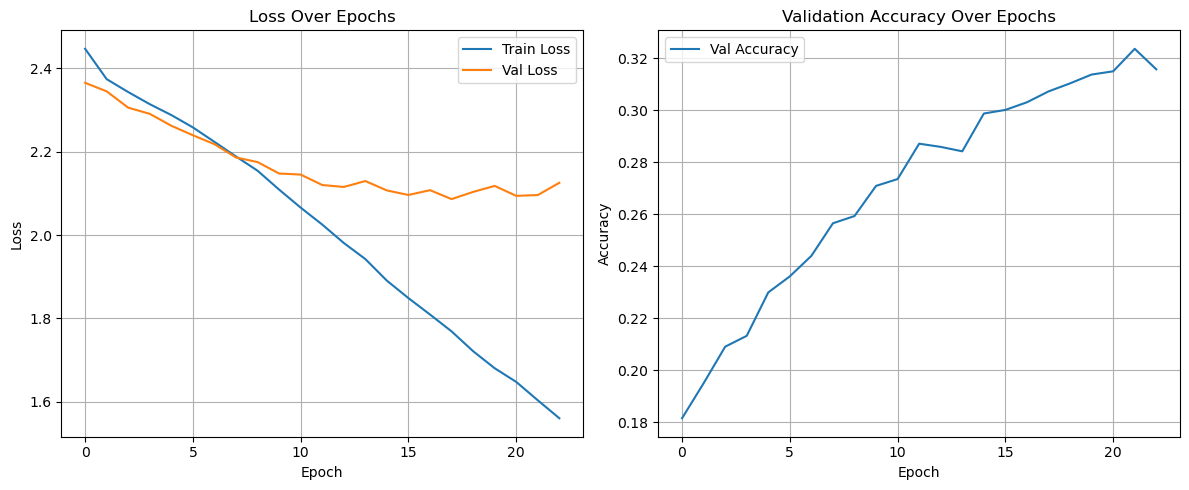

Best model saved to 'best_model.pth'


In [9]:
# Restore best weights (lowest val loss)
model.load_state_dict(best_model_wts)

# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the best model
best_model_path = "best_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
}, best_model_path)
print(f"Best model saved to '{best_model_path}'")


In [12]:
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

all_predictions = []
all_labels_list = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels_list.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels_list = np.array(all_labels_list)

test_accuracy = accuracy_score(all_labels_list, all_predictions)
recall_per_class = recall_score(all_labels_list, all_predictions, average=None, zero_division=0)
precision_per_class = precision_score(all_labels_list, all_predictions, average=None, zero_division=0)
macro_recall = recall_score(all_labels_list, all_predictions, average='macro', zero_division=0)
macro_precision = precision_score(all_labels_list, all_predictions, average='macro', zero_division=0)

print("\nTest Set Results:")
print(f"Accuracy         : {test_accuracy:.4f}")
print(f"Macro-Recall     : {macro_recall:.4f}")
print(f"Macro-Precision  : {macro_precision:.4f}")


C:\Users\yozev\AppData\Local\Temp\ipykernel_9400\2391605330.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


Test Set Results:
Accuracy         : 0.3241
Macro-Recall     : 0.3268
Macro-Precision  : 0.3378
